In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rrcf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read csv file
df_turbidity = pd.read_csv("Data_Raw_Water.csv")
print('The number of samples of the data ', len(df_turbidity))
df_turbidity.head()

The number of samples of the data  2658


,time,turbidity,pH
0,2020-11-04 11:00:31.822439+00:00,21.063435,7.34
1,2020-11-04 11:01:22.124333+00:00,20.868153,7.33
2,2020-11-04 11:01:51.663062+00:00,20.584553,7.32
3,2020-11-04 11:02:29.373718+00:00,21.185328,7.33
4,2020-11-04 11:03:45.517010+00:00,21.063435,7.32


In [3]:
# Convert dataframe to array
turbidity_train= np.array(df_turbidity['turbidity'])

In [4]:
# Set tree parameters
num_trees = 100
shingle_size = 1
tree_size = 500


In [5]:
# Create a forest of empty trees
forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)


In [6]:
# Use the "shingle" generator to create rolling window
points = rrcf.shingle(turbidity_train, size=shingle_size)

# Create a dict to store anomaly score of each point
avg_codisp = {}

In [7]:
%%time
# Display prediction result

for index, point in enumerate(points):
    # For each tree in the forest...
    for tree in forest:
        # If tree is above permitted size, drop the oldest point
        # (FIFO)
        if len(tree.leaves) > tree_size:
            tree.forget_point(index - tree_size)
        # Insert the new point into the tree
        tree.insert_point(point, index=index)
        # Compute codisp on the new point and take the average among
        # all trees
        if not index in avg_codisp:
            avg_codisp[index] = 0
        avg_codisp[index] += tree.codisp(index) / num_trees

Wall time: 2min 26s


In [8]:
# Convert score dictionary to data frame.
turbidity_result = pd.DataFrame.from_dict(avg_codisp,'index')

In [9]:
# Merge score with data.
df_turbidity['Score'] = turbidity_result

In [13]:
#Try different values of threshold to get anomalies.
anomalies = df_turbidity.loc[df_turbidity['Score']>30]
anomalies_only = anomalies[['time', 'turbidity','Score']]
anomalies_only

,time,turbidity,Score
57,2020-11-05 11:28:33.992949+00:00,23.856159,32.509143
76,2020-11-05 21:03:38.902611+00:00,37.734662,41.341389
79,2020-11-05 23:04:43.071267+00:00,47.734662,31.095167
258,2020-11-10 07:32:12.367390+00:00,11.611506,151.931857
290,2020-11-11 00:41:18.328484+00:00,15.734662,77.083077
...,...,...,...
2631,2021-01-03 20:17:11.567674+00:00,11.856159,41.855591
2632,2021-01-03 20:47:27.705902+00:00,10.611506,49.176667
2633,2021-01-03 21:17:43.689770+00:00,10.633270,35.438833
2634,2021-01-03 21:47:59.749381+00:00,11.856159,33.996051


In [11]:
len(anomalies)

187

Text(0.5, 1.0, 'A Plot of Water Turbidity Data (Red) and Anomaly Score (Blue)\n')

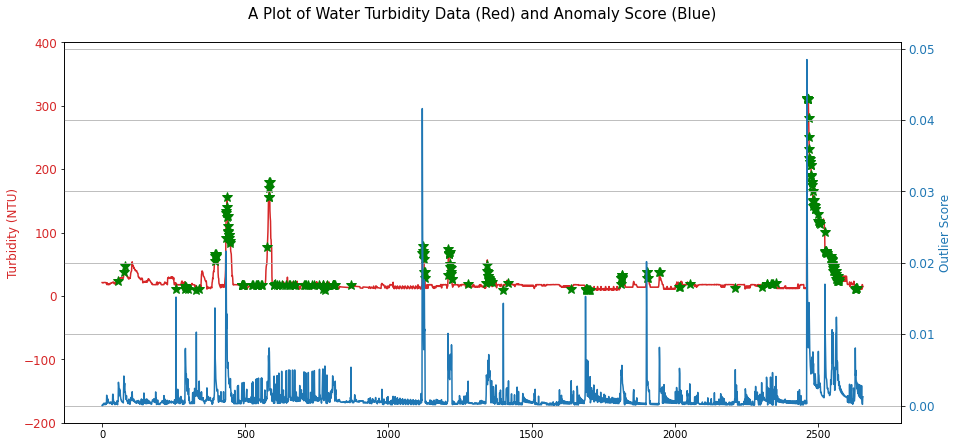

In [14]:
for index in range(len(avg_codisp)):
    avg_codisp[index]=avg_codisp[index]/100
    
fig, ax1 = plt.subplots(figsize=(15, 7))
color = 'tab:red'
ax1.set_ylabel('Turbidity (NTU)', color=color, size=12)
ax1.plot(turbidity_train, color=color)
plt.plot(anomalies['turbidity'], "g*", markersize =10)
ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
ax1.set_ylim(-200,400)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Outlier Score', color=color, size=12)
ax2.plot(pd.Series(avg_codisp).sort_index(), color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2.grid('off')
#ax2.set_ylim(0,500)
plt.title('A Plot of Water Turbidity Data (Red) and Anomaly Score (Blue)\n', size=15)